# Imports

- DataCamp package versions vs. local versions:
  - `sklearn v0.20.4` vs. `1.3.2`
  - `numpy v1.17.4` vs. `1.26.3`
  - `pandas v0.24.2` vs. `2.1.4`
  - `matplotlib v3.1.2` vs. `3.8.1`
  - `seaborn n/a` vs. `0.13.1`

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from typing import List, Union

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion

from sklearn.ensemble import RandomForestClassifier

In [4]:
import sys
sys.path.append(r'D:\users\trenton\Dropbox\PythonProjects\DataCamp\functions')

from multilabel import multilabel_train_test_split
from score_sub import score_submission

In [5]:
pd.set_option('display.max_columns', 700)
pd.set_option('display.max_rows', 400)
pd.set_option('display.min_rows', 10)
pd.set_option('display.expand_frame_repr', True)

# Saving data from DataCamp to a local csv

```python
# output the data to a format that can be copied and pasted into notepad++
# find all non and replace with np.nan
# copy all of lists and replace ... in data = np.array([...])
# print the columns names df.columns.tolist() and then create a variable in a notebook
# create a dataframe with df = pd.DataFrame(data=data, columns=columns)

# create the dataframe in the DataCamp console
df = pd.read_csv('TrainingData.csv')  # do not specify index_col=0

# print each row as a list with a comma at the end and then copy all of the lists into notepad++
for r in df.to_numpy():
    print(list(r), ',')

# print the column names and copy them
df.columns.tolist()

# in jupyterlab
data = np.array([...])  # replace ... with the cleaned lists from notepad++
columns = ...  # pasted from DataCamp console

df = pd.DataFrame(data=data, columns=columns)

df.to_csv('TrainingData.csv', index=False)
```

# Exploring the Raw Data

In [6]:
df = pd.read_csv('data/2024-01-19_school_budgeting_with_machine_learning_in_python/TrainingData.csv', index_col=0)

In [7]:
df.head()

,Function,Use,Sharing,Reporting,Student_Type,Position_Type,Object_Type,Pre_K,Operating_Status,Object_Description,Text_2,SubFund_Description,Job_Title_Description,Text_3,Text_4,Sub_Object_Description,Location_Description,FTE,Function_Description,Facility_or_Department,Position_Extra,Total,Program_Description,Fund_Description,Text_1
198,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplemental *,NaN,Operation and Maintenp.nance of Plant Services,NaN,NaN,NaN,Non-Certificated Salaries And Wages,NaN,NaN,Care and Upkeep of Building Services,NaN,NaN,-8291.86,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I CARRYOVER
209,Student Transportation,NO_LABEL,Shared Services,Non-School,NO_LABEL,NO_LABEL,Other Non-Compensation,NO_LABEL,PreK-12 Operating,REPAIR AND MAINTENANCE SERVICES,NaN,PUPIL TRANSPORTATION,NaN,NaN,NaN,NaN,ADMIN. SERVICES,NaN,STUDENT TRANSPORT SERVICE,NaN,NaN,618.29,PUPIL TRANSPORTATION,General Fund,NaN
750,Teacher Compensation,Instruction,School Reported,School,Unspecified,Teacher,Base Salary/Compensation,Non PreK,PreK-12 Operating,Personal Services - Teachers,NaN,NaN,TCHER 5TH GRADE,NaN,Regular Instruction,NaN,NaN,1.0,NaN,NaN,TEACHER,49768.82,Instruction - Regular,General Purpose School,NaN
931,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,General Supplies,NaN,NaN,NaN,NaN,NaN,General Supplies,NaN,NaN,Instruction,Instruction And Curriculum,NaN,-1.02,"""Title I, Part A Schoolwide Activities Related...",General Operating Fund,NaN
1524,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,NO_LABEL,Non-Operating,Supplies and Materials,NaN,Community Services,NaN,NaN,NaN,Supplies And Materials,NaN,NaN,Other Community Services *,NaN,NaN,2304.43,NaN,Title I - Disadvantaged Children/Targeted Assi...,TITLE I PI+HOMELESS


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1560 entries, 198 to 101861
Data columns (total 25 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Function                1560 non-null   object 
 1   Use                     1560 non-null   object 
 2   Sharing                 1560 non-null   object 
 3   Reporting               1560 non-null   object 
 4   Student_Type            1560 non-null   object 
 5   Position_Type           1560 non-null   object 
 6   Object_Type             1560 non-null   object 
 7   Pre_K                   1560 non-null   object 
 8   Operating_Status        1560 non-null   object 
 9   Object_Description      1461 non-null   object 
 10  Text_2                  382 non-null    object 
 11  SubFund_Description     1183 non-null   object 
 12  Job_Title_Description   1131 non-null   object 
 13  Text_3                  296 non-null    object 
 14  Text_4                  193 non-null    o

## Summarize the Data

In [9]:
# Print the summary statistics
df.describe()

,FTE,Total
count,449.000000,1.542000e+03
mean,0.493532,1.446867e+04
std,0.452844,7.916752e+04
min,-0.002369,-1.044084e+06
25%,0.004310,1.108111e+02
50%,0.440000,7.060299e+02
75%,1.000000,5.347760e+03
max,1.047222,1.367500e+06


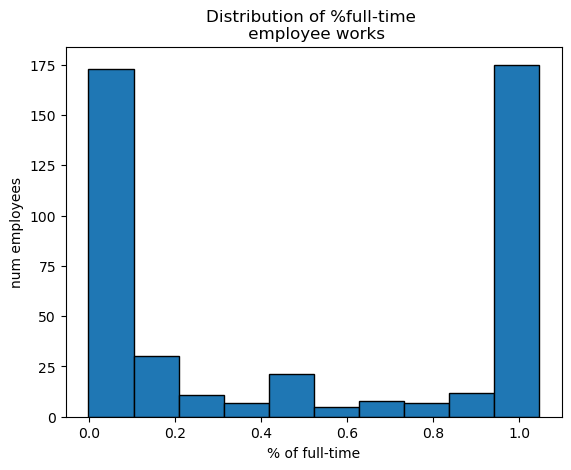

In [10]:
# Create the histogram
plt.hist(df['FTE'].dropna(), ec='k')  # .dropna() isn't needed

# Add title and labels
plt.title('Distribution of %full-time \n employee works')
plt.xlabel('% of full-time')
plt.ylabel('num employees')

# Display the histogram
plt.show()

**The high variance in expenditures makes sense (some purchases are cheap some are expensive). Also, it looks like the FTE column is bimodal. That is, there are some part-time and some full-time employees.**

In [11]:
df.dtypes.value_counts()

object     23
float64     2
Name: count, dtype: int64

## Encode the Labels as Categorical Variables

In [12]:
LABELS_td = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']
categorize_label = lambda x: x.astype('category')
df[LABELS_td] = df[LABELS_td].apply(categorize_label)
print(df[LABELS_td].dtypes)

Function            category
Use                 category
Sharing             category
Reporting           category
Student_Type        category
Position_Type       category
Object_Type         category
Pre_K               category
Operating_Status    category
dtype: object


## Counting Unique Labels

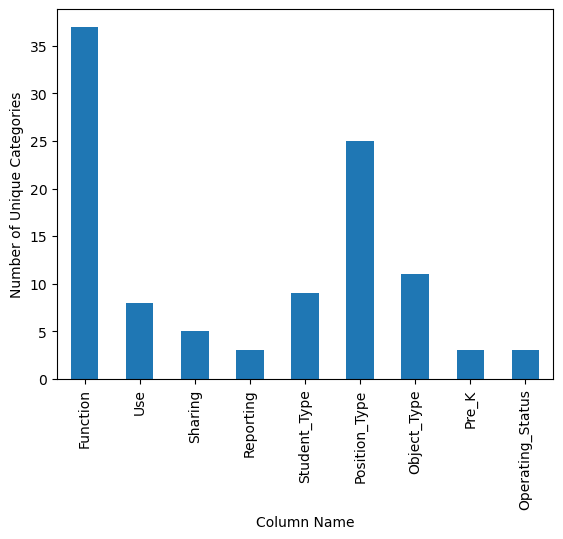

In [13]:
num_unique_labels = df[LABELS_td].apply(pd.Series.nunique)
ax = num_unique_labels.plot(kind='bar', ylabel='Number of Unique Categories', xlabel='Column Name')

## `def compute_log_loss`

In [14]:
def compute_log_loss(predicted: Union[float, List[float]], actual: [int, List[int]], eps: float=1e-14) -> float:
    """
    Computes the logarithmic loss between predicted and 
    actual when these are 1D arrays

    :param predicted: The predicted probabilities as floats between 0-1
    :param actual: The actual binary labels. Either 0 or 1
    :param eps (optional): log(0) is inf, so we need to offset our
                           precidted values slightly by eps from 0 to 1.
    """

    predicted = np.clip(predicted, eps, 1 - eps)
    loss = -1 * np.mean(actual * np.log(predicted)
                        + (1 - actual)
                        * np.log(1 - predicted))
    return loss

In [15]:
data = [(0.85, 1), (0.99, 0), (0.51, 0)]

for p, y in data:
    print(compute_log_loss(p, y))

0.16251892949777494
4.605170185988091
0.7133498878774648


**Lowest: A, Middle: C, Highest: B**

**Of the two incorrect predictions, B will have a higher log loss because it is confident and wrong.**

## Computing log loss with Numpy

In [16]:
correct_confident = np.array([0.95, 0.95, 0.95, 0.95, 0.95, 0.05, 0.05, 0.05, 0.05, 0.05])
correct_not_confident = np.array([0.65, 0.65, 0.65, 0.65, 0.65, 0.35, 0.35, 0.35, 0.35, 0.35])
wrong_not_confident = np.array([0.35, 0.35, 0.35, 0.35, 0.35, 0.65, 0.65, 0.65, 0.65, 0.65])
wrong_confident = np.array([0.05, 0.05, 0.05, 0.05, 0.05, 0.95, 0.95, 0.95, 0.95, 0.95])
actual_labels = np.array([1., 1., 1., 1., 1., 0., 0., 0., 0., 0.])

In [17]:
# Compute and print log loss for 1st case
correct_confident_loss = compute_log_loss(correct_confident, actual_labels)
print("Log loss, correct and confident: {}".format(correct_confident_loss)) 

# Compute log loss for 2nd case
correct_not_confident_loss = compute_log_loss(correct_not_confident, actual_labels)
print("Log loss, correct and not confident: {}".format(correct_not_confident_loss)) 

# Compute and print log loss for 3rd case
wrong_not_confident_loss = compute_log_loss(wrong_not_confident, actual_labels)
print("Log loss, wrong and not confident: {}".format(wrong_not_confident_loss)) 

# Compute and print log loss for 4th case
wrong_confident_loss = compute_log_loss(wrong_confident, actual_labels)
print("Log loss, wrong and confident: {}".format(wrong_confident_loss)) 

# Compute and print log loss for actual labels
actual_labels_loss = compute_log_loss(actual_labels, actual_labels)
print("Log loss, actual labels: {}".format(actual_labels_loss)) 

Log loss, correct and confident: 0.05129329438755058
Log loss, correct and not confident: 0.4307829160924542
Log loss, wrong and not confident: 1.049822124498678
Log loss, wrong and confident: 2.9957322735539904
Log loss, actual labels: 9.99200722162646e-15


**Log loss penalizes highly confident wrong answers much more than any other type. This will be a good metric to use on your models.**

# Creating a simple first model

## It's time to build a model

```python
data_to_train = df[NUMERIC_COLUMNS].fillna(-1000)
labels_to_use = pd.get_dummies(df[LABELS])

X_train, X_test, y_train, y_test = multilabel_train_test_split(data_to_train, labels_to_use, size=0.2, seed=123)

clf = OneVsRestClassifier(LogisticRegression())
clf.fit(X_train, y_train)
```

### Setting up a train-test split in scikit-learn

In [18]:
NUMERIC_COLUMNS_td = df.select_dtypes(include='number').columns.tolist()

# Create the new DataFrame: numeric_data_only
numeric_data_only = df[NUMERIC_COLUMNS_td].fillna(-1000)

# Get labels and convert to dummy variables: label_dummies
label_dummies = pd.get_dummies(df[LABELS_td])

# Create training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(numeric_data_only,
                                                               label_dummies,
                                                               size=0.2, 
                                                               seed=123)

# Print the info
print("X_train info:")
print(X_train.info())
print("\nX_test info:")  
print(X_test.info())
print("\ny_train info:")  
print(y_train.info())
print("\ny_test info:")  
print(y_test.info()) 

X_train info:
<class 'pandas.core.frame.DataFrame'>
Index: 1040 entries, 198 to 101861
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     1040 non-null   float64
 1   Total   1040 non-null   float64
dtypes: float64(2)
memory usage: 24.4 KB
None

X_test info:
<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 209 to 448628
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   FTE     520 non-null    float64
 1   Total   520 non-null    float64
dtypes: float64(2)
memory usage: 12.2 KB
None

y_train info:
<class 'pandas.core.frame.DataFrame'>
Index: 1040 entries, 198 to 101861
Columns: 104 entries, Function_Aides Compensation to Operating_Status_PreK-12 Operating
dtypes: bool(104)
memory usage: 113.8 KB
None

y_test info:
<class 'pandas.core.frame.DataFrame'>
Index: 520 entries, 209 to 448628
Columns: 104 entries, Function_Aides Compensation to Operating_Stat

D:\users\trenton\Dropbox\PythonProjects\DataCamp\functions\multilabel.py:31: UserWarning: Size less than number of columns * min_count, returning 520 items instead of 312.0.
  warn(msg.format(y.shape[1] * min_count, size))


### Training a model

In [19]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit the classifier to the training data
clf.fit(X_train, y_train)

# Print the accuracy
print("Accuracy: {}".format(clf.score(X_test, y_test)))

Accuracy: 0.0


**The good news is that your workflow didn't cause any errors. The bad news is that your model scored the lowest possible accuracy: 0.0! But hey, you just threw away ALL of the text data in the budget. Later, you won't. Before you add the text data, let's see how the model does when scored by log loss.**

## Making predictions

```python
houldout = pd.read_csv('HoldoutData.csv', index_col=0)
holdout = holdout[NUMERIC_COLUMNS].fillna(-1000)
predictions = clf.predict_proba(holdout)
```

- Using `.predict()`
  - would result in an output of 0 or 1
  - Log loss penalized being confident and wrong
  - Worse performance compared to `.predict_proba()`

- Format and submit predictions
```python
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS], prefix_sep='__').columns, index=houldout.index, data=predictions)
prediction_df.to_csv('predictions.csv')
score = score_submission(pred_path='predictions.csv')
```

### Use your model to predict values on holdout data

In [20]:
# Instantiate the classifier: clf
clf = OneVsRestClassifier(LogisticRegression())

# Fit it to the training data
clf.fit(X_train, y_train)

# Load the holdout data: holdout
holdout = pd.read_csv('data/2024-01-19_school_budgeting_with_machine_learning_in_python/HoldoutData.csv', index_col=0)

# Generate predictions: predictions
NUMERIC_COLUMNS_hd = holdout.select_dtypes(include='number').columns
predictions = clf.predict_proba(holdout[NUMERIC_COLUMNS_hd].fillna(-1000))

### Writing out your results to a csv for submission

In [21]:
# Format predictions in DataFrame: prediction_df
# pd.get_dummies(df[LABELS], ...) is correctly using df, not holdout
prediction_df = pd.DataFrame(columns=pd.get_dummies(df[LABELS_td], prefix_sep='__').columns,
                             index=holdout.index,
                             data=predictions)

# Save prediction_df to csv
prediction_df.to_csv('data/2024-01-19_school_budgeting_with_machine_learning_in_python/predictions.csv')

In [22]:
# requires functions and variables from https://goodboychan.github.io/python/datacamp/machine_learning/2020/06/05/01-School-Budgeting-with-Machine-Learning-in-Python.html
# BOX_PLOTS_COLUMN_INDICES, def _multi_multi_log_loss, and def score_submissio

# Submit the predictions for scoring: score
score = score_submission(pred_path='data/2024-01-19_school_budgeting_with_machine_learning_in_python/predictions.csv', holdout_path='data/2024-01-19_school_budgeting_with_machine_learning_in_python/TestSetLabelsSample.csv')

# Print score
print('Your model, trained with numeric data only, yields logloss score: {}'.format(score))

Your model, trained with numeric data only, yields logloss score: 1.9922002736361633


**Even though your basic model scored 0.0 accuracy, it nevertheless performs better than the benchmark score of 2.0455. You've now got the basics down and have made a first pass at this complicated supervised learning problem. It's time to step up your game and incorporate the text data.**

## A very brief introduction to NLP

- Data for NLP:
  - Text, documents, speech, ...
- Tokenization
  - Splitting a string into segments
  - Store segments as list
- Example: "Natural Language Processing"
  - ['Natural', 'Language', 'Processing']

- Tokenize on whitespace
  - Petro-vend fuel and fluids
    - Petro-vend | fuel | and | fluids
- Tokenize on whitespace and punctuation
  - Petro | vend | fuel | and | fluids
 
- Bag of words representation
  - Count the umber of times a particular token appears
  - 'Bag of words'
    - Count the number of times a word was pulled out of the bag
- The approach discards information about word order
  - 'Red, not blue' is the same as 'blue, not red'
 
- 1-gram, 2-gram, ..., n-gram
  - ![][1]
 
[1]: https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/2024-01-19_school_budgeting_with_machine_learning_in_python/sb01.jpg

## A very brief introduction to NLP

- Data for NLP:
  - Text, documents, speech, ...
- Tokenization
  - Splitting a string into segments
  - Store segments as list
- Example: "Natural Language Processing"
  - ['Natural', 'Language', 'Processing']

- Tokenize on whitespace
  - Petro-vend fuel and fluids
    - Petro-vend | fuel | and | fluids
- Tokenize on whitespace and punctuation
  - Petro | vend | fuel | and | fluids
 
- Bag of words representation
  - Count the umber of times a particular token appears
  - 'Bag of words'
    - Count the number of times a word was pulled out of the bag
- The approach discards information about word order
  - 'Red, not blue' is the same as 'blue, not red'
 
- 1-gram, 2-gram, ..., n-gram
  - ![][1]
 
[1]: https://raw.githubusercontent.com/trenton3983/DataCamp/master/Images/2024-01-19_school_budgeting_with_machine_learning_in_python/sb01.jpg

### Tokenizating text

- 6

### Testing your NLP credentials with n-grams

- 12 - The number of `1-grams + 2-grams + 3-grams` is `5 + 4 + 3 = 12`.

## Representing text numerically

**Scikit-learn tools for bag-of-words**

- `CountVectorizer()`
  - Tokenizes all the strings
  - Builds a 'vocabulary'
  - Counts the occurrences of each token in the vocabulary
 
**Using `CountVectorizer() on a column of main dataset**

```python
from sklearn.feature_extraction.text import CountVecotrizer

TOKENS_BASIC = '\\\\S+(?=\\\\s+)'
df.Program_Description.fillna('', inplace=True)
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

vec_basic.fit(df.Program_Description)
msg = 'There are {} token in Program_Desction if tokean are any non-whitespace'
print(msg.format(len(vec_basic.get_feature_names())))
```


### Creating a bag-of-words in scikit-learn

In this exercise, you'll study the effects of tokenizing in different ways by comparing the bag-of-words representations resulting from different token patterns.

You will focus on one feature only, the `Position_Extra` column, which describes any additional information not captured by the `Position_Type` label.

For example, in the Shell you can check out the budget item in row 8960 of the data using `df.loc[8960]`. Looking at the output reveals that this `Object_Description` is overtime pay. For who? The Position Type is merely "other", but the Position Extra elaborates: "BUS DRIVER". Explore the column further to see more instances. It has a lot of NaN values.

Your task is to turn the raw text in this column into a bag-of-words representation by creating tokens that contain only alphanumeric characters.

For comparison purposes, the first 15 tokens of `vec_basic`, which splits `df.Position_Extra` into tokens when it encounters only whitespace characters, have been printed along with the length of the representation.

**Instructions**

- Import `CountVectorizer` from `sklearn.feature_extraction.text`.
- Fill missing values in `df.Position_Extra` using `.fillna('')` to replace NaNs with empty strings. Specify the additional keyword argument `inplace=True` so that you don't have to assign the result back to `df`.
- Instantiate the `CountVectorizer` as `vec_alphanumeric` by specifying the `token_pattern` to be `TOKENS_ALPHANUMERIC`.
- Fit `vec_alphanumeric` to `df.Position_Extra`.
- Hit submit to see the `len` of the fitted representation as well as the first 15 elements, and compare to `vec_basic`.

In [23]:
# Create the token pattern: TOKENS_ALPHANUMERIC
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Fill missing values in df.Position_Extra
df.Position_Extra.fillna('', inplace=True)

# Instantiate the CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Fit to the data
vec_alphanumeric.fit(df.Position_Extra)

# Print the number of tokens and first 15 tokens
msg = "There are {} tokens in Position_Extra if we split on non-alpha numeric"
print(msg.format(len(vec_alphanumeric.get_feature_names_out())))
print(vec_alphanumeric.get_feature_names_out()[:15])

There are 123 tokens in Position_Extra if we split on non-alpha numeric
['1st' '2nd' '3rd' 'a' 'ab' 'additional' 'adm' 'administrative' 'and'
 'any' 'art' 'assessment' 'assistant' 'asst' 'athletic']


**Treating only alpha-numeric characters as tokens gives you a smaller number of more meaningful tokens.**

### Combining text columns for tokenization

In order to get a bag-of-words representation for all the text data in our DataFrame, you must first convert the text data in each row of the DataFrame into a single string.

In the previous exercise, this wasn't necessary because you only looked at one column of data, so each row was already just a single string. `CountVectorizer` expects each row to just be a single string, so in order to use all of the text columns, you'll need a method to turn a list of strings into a single string.

In this exercise, you'll complete the function definition `combine_text_columns()`. When completed, this function will convert all training text data in your DataFrame to a single string per row that can be passed to the vectorizer object and made into a bag-of-words using the `.fit_transform()` method.

Note that the function uses `NUMERIC_COLUMNS` and `LABELS` to determine which columns to drop. These lists have been loaded into the workspace.

**Instructions**

- Use the `.drop()` method on `data_frame` with `to_drop` and `axis=` as arguments to drop the non-text data. Save the result as `text_data`.
- Fill in missing values (inplace) in `text_data` with blanks (""), using the `.fillna()` method.
- Complete the `.apply()` method by writing a lambda function that uses the `.join()` method to join all the items in a row with a space in between.

In [24]:
# Define combine_text_columns()
def combine_text_columns(data_frame: pd.DataFrame, to_drop: list=NUMERIC_COLUMNS_td + LABELS_td) -> pd.Series:
    """ converts all text in each row of data_frame to single vector """
    
    # Drop non-text columns that are in the df
    to_drop = set(to_drop) & set(data_frame.columns.tolist())
    text_data = data_frame.drop(to_drop, axis=1)
    
    # Replace nans with blanks
    text_data.fillna('', inplace=True)
    
    # Join all text items in a row that have a space in between
    return text_data.apply(lambda x: " ".join(x), axis=1)

### What's in a token?

Now you will use `combine_text_columns` to convert all training text data in your DataFrame to a single vector that can be passed to the vectorizer object and made into a bag-of-words using the `.fit_transform()` method.

You'll compare the effect of tokenizing using any non-whitespace characters as a token and using only alphanumeric characters as a token.

**Instructions**

- Import `CountVectorizer` from `sklearn.feature_extraction.text`.
- Instantiate `vec_basic` and `vec_alphanumeric` using, respectively, the `TOKENS_BASIC` and `TOKENS_ALPHANUMERIC` patterns.
- Create the text vector by using the `combine_text_columns()` function on `df`.
- Using the `.fit_transform()` method with `text_vector`, fit and transform first `vec_basic` and then `vec_alphanumeric`. Print the number of tokens they contain.

In [25]:
# Create the basic token pattern
TOKENS_BASIC = '\\S+(?=\\s+)'

# Create the alphanumeric token pattern
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'

# Instantiate basic CountVectorizer: vec_basic
vec_basic = CountVectorizer(token_pattern=TOKENS_BASIC)

# Instantiate alphanumeric CountVectorizer: vec_alphanumeric
vec_alphanumeric = CountVectorizer(token_pattern=TOKENS_ALPHANUMERIC)

# Create the text vector
text_vector = combine_text_columns(df)

# Fit and transform vec_basic
vec_basic.fit_transform(text_vector)

# Print number of tokens of vec_basic
print("There are {} tokens in the dataset".format(len(vec_basic.get_feature_names_out())))

# Fit and transform vec_alphanumeric
vec_alphanumeric.fit_transform(text_vector)

# Print number of tokens of vec_alphanumeric
print("There are {} alpha-numeric tokens in the dataset".format(len(vec_alphanumeric.get_feature_names_out())))

There are 1406 tokens in the dataset
There are 1118 alpha-numeric tokens in the dataset


**Notice that tokenizing on alpha-numeric tokens reduced the number of tokens, just as in the last exercise. We'll keep this in mind when building a better model with the Pipeline object next.**

# Improving your model

## Pipelines, feature & text preprocessing

1. **Pipelines, feature & text preprocessing**: You've submitted your first simple model. Now it's time to combine what we've learned about NLP with our model pipeline and incorporate the text data into our algorithm.
- Repeatable way to go from raw data to trained model
- Pipeline object takes sequential list of steps
  - Output of one step is input to next step
- Each step is a tuple with two elements
  - Name: string
  - Transform: obj implementing .fit() and .transform()
- Flexible: a step can itself be another pipeline!

2. **The pipeline workflow**: The supervised learning course introduced pipelines, which are a repeatable way to go from raw data to a trained machine learning model. The scikit-learn Pipeline object takes a sequential list of steps where the output of one step is the input to the next. Each step is represented with a name for the step, that is simply a string, and an object that implements the fit and the transform methods. A good example is the `CountVectorizer` that we used earlier. As we'll see Pipelines are a very flexible way to represent your workflow. In fact, you can even have a sub-pipeline as one of the steps! The beauty of the Pipeline is that it encapsulates every transformation from raw data to a trained model.

```python
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
pl = Pipeline([('clf', OneVsRestClassifier(LogisticRegression()))])
```

3. **Instantiate simple pipeline with one step**: After importing the relevant modules, we'll start with a one-step pipeline. Although we don't need a pipeline for a single step, this exercise will get us familiar with the syntax. Remember, we create a Pipeline by passing it a series of named steps. In this case the name is the string 'clf', and the step is the one-vs-rest logistic regression classifier we created earlier.

4. **Train and test with sample numeric data**: The sample dataset we've been working with has numeric data in the numeric columns and the with missing column. We'll start by building a model to predict the label column with the numeric data.

5. **Train and test with sample numeric data**: First, we'll use the train_test split function from sklearn dot model_selection. Our X will just be the numeric column, and our Y will be the dummy encoding of the label column. We'll call the fit method on our Pipeline, just like a normal classifier in sklearn. We can see that it returns a Pipeline that has one step to do our logistic regression.

```python
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']], pd.get_dummies(sample_df['label']), random_state=2)
pl.fit(X_train, y_train)
```

6. **Train and test with sample numeric data**: By using the score function on our pipeline, we can see how our Pipeline performs on the test set. The default scoring method for this classifier is accuracy. That's good enough for our sample dataset.

```python
accuracy = pl.score(X_test, y_test)
print('accuracy on numeric data, no nans: ', accuracy)
```

7. **Adding more steps to the pipeline**: Let's add the with_missing column to our training set. Oops! Now when we call fit, we see a value error that explains that our input has NaN values.

```python
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']], pd.get_dummies(sample_df['label']), random_state=2)
pl.fit(X_train, y_train)
```

8. **Preprocessing numeric features with missing data**: To address this, we'll add an Imputer to our pipeline, which will fill in the NaN values. To do so, we add a step to the Pipeline with the name 'imp' and an Imputer object. The default imputation in scikit-learn is to fill missing values with the mean of the column in question. You can look at the documentation of the Imputer object to see other possible imputation strategies.

```python
from sklearn.preprocessing import Imputer
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']], pd.get_dummies(sample_df['label']), random_state=2)
pl = Pipeline([('imp', Imputer()), ('clf', OneVsRestClassifier(LogisticRegression()))])
```

9. **Preprocessing numeric features with missing data**: We can call fit and score on the new pipeline, just like we did before. But, in this case our model also includes the column with_missing which had NaN values that were imputed.

```python
pipeline.fit(X_train, y_train)
accuracy = pl.score(X_test, y_test)
print('accuracy on all numeric, incl nans: ', accuracy)
```

### Instantiate pipeline

In order to make your life easier as you start to work with all of the data in your original DataFrame, `df`, it's time to turn to one of scikit-learn's most useful objects: the `Pipeline`.

For the next few exercises, you'll reacquaint yourself with pipelines and train a classifier on some synthetic (sample) data of multiple datatypes before using the same techniques on the main dataset.

The sample data is stored in the DataFrame, `sample_df`, which has three kinds of feature data: numeric, text, and numeric with missing values. It also has a label column with two classes, `a` and `b`.

In this exercise, your job is to instantiate a pipeline that trains using the `numeric` column of the sample data.

**Instructions**

- Import `Pipeline` from `sklearn.pipeline`.
- Create training and test sets using the numeric data only. Do this by specifying `sample_df[['numeric']]` in `train_test_split()`.
- Instantiate a pipeline as pl by adding the classifier step. Use a name of `'clf'` and the same classifier from Chapter 2: `OneVsRestClassifier(LogisticRegression())`.
- Fit your pipeline to the training data and compute its accuracy to see it in action! Since this is toy data, you'll use the default scoring method for now. In the next chapter, you'll return to log loss scoring.

In [26]:
sample_df = pd.read_csv('data/2024-01-19_school_budgeting_with_machine_learning_in_python/sample_df.csv')

sample_df['text'].fillna('', inplace=True)

In [27]:
# Split and select numeric data only, no nans 
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric']], pd.get_dummies(sample_df['label']),  random_state=22)

# Instantiate Pipeline object: pl
pl = Pipeline([('clf', OneVsRestClassifier(LogisticRegression()))])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("Accuracy on sample data - numeric, no nans: ", accuracy)

Accuracy on sample data - numeric, no nans:  0.62


**Now it's time to incorporate numeric data with missing values by adding a preprocessing step!**

### Preprocessing numeric features

What would have happened if you had included the with `'with_missing'` column in the last exercise? Without imputing missing values, the pipeline would **not** be happy (try it and see). So, in this exercise you'll improve your pipeline a bit by using the `Imputer()` imputation transformer from scikit-learn to fill in missing values in your sample data.

By default, the [imputer transformer][1] replaces NaNs with the mean value of the column. That's a good enough imputation strategy for the sample data, so you won't need to pass anything extra to the imputer.

After importing the transformer, you will edit the steps list used in the previous exercise by inserting a `(name, transform)` tuple. Recall that steps are processed sequentially, so make sure the new tuple encoding your preprocessing step is put in the right place.

The `sample_df` is in the workspace, in case you'd like to take another look. Make sure to select **both** numeric columns- in the previous exercise we couldn't use `with_missing` because we had no preprocessing step!

**Instructions**

- Import `Imputer` from `sklearn.preprocessing`.
- Create training and test sets by selecting the correct subset of `sample_df`: `numeric` and `with_missing`.
- Add the tuple `('imp', Imputer())` to the correct position in the pipeline. `Pipeline` processes steps sequentially, so the imputation step should come __before__ the classifier step.
- Complete the `.fit()` and `.score()` methods to fit the pipeline to the data and compute the accuracy.

[1]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html

In [28]:
# Create training and test sets using only numeric data
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Insantiate Pipeline object: pl
pl = Pipeline([('imp', SimpleImputer()), ('clf', OneVsRestClassifier(LogisticRegression()))])

# Fit the pipeline to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("Accuracy on sample data - all numeric, incl nans: ", accuracy)

Accuracy on sample data - all numeric, incl nans:  0.636


**Now you know how to use preprocessing in pipelines with numeric data, and it looks like the accuracy has improved because of it! Text data preprocessing is next!**

## Test features and feature union

1. **Text features and feature unions**: In this video, we'll look at how we process text data in a pipeline and then how we put it all together.

2. **Preprocessing text features**: Our sample dataframe contains one column we haven't used yet, the text column. First, we'll change our train and test data just to be working with the text data for now. Then, we'll add a step to our Pipeline with the name vec and the CountVectorizer object from scikit-learn. Now our pipeline will use the CountVectorizer on our dataset, and then it will pass the result into our classifier.

```python
from sklearn.feature_extraction.text import CountVectorizer
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'], pd.get_dummies(sample_df['label']), random_state=2)
pl = Pipeline([('vec', CountVectorizer()), ('clf', OneVsRestClassifier(LogisticRegression()))])
```

3. **Preprocessing text features**: Again, we can call the fit and score methods on the Pipeline. The score function now reports our accuracy if we just use the text data.

```python
pl.fit(X_train, y_train)

accuracy = pl.score(X_test, y_test)
print('accuracy on sample data: ', accuracy)
```

4. **Preprocessing multiple dtypes**: Let's say we want to use all of our data in a single pipeline. We can't just have a Pipeline that has a `CountVectorizer` step, Imputation step, and then a classifier. The `CountVectorizer` won't know what to do with the numeric columns, and we don't want to perform imputation on the text columns. In order to build our pipeline, we need to separately operate on the text columns and on the numeric columns. There are two tools: FunctionTransformer and FeatureUnion that will help us build a Pipeline to work with both our text and numeric data. The first utility that we cover is the FunctionTransformer.
- Want to use all available features in one pipeline
- Problem
  - Pipeline steps for numeric and text preprocessing can't follow each other
  - e.g., output of `CountVectorizer` can't be input to `Imputer`
- Solution
  - `FunctionTransformer()` & `FeatureUnion()`

5. **FunctionTransformer**: `FunctionTransformer` has a simple job: take a Python function, and turn it into an object that the scikit-learn Pipeline can understand. We'll write two simple functions: one that takes the whole dataframe, and returns just the numeric columns. The other will take the whole dataframe and return just the text columns. Using these function transformers, we can build a separate Pipeline for our numeric data and for our text data.
- Turns a Python function into an object that a scikit-learn pipeline can understand
- Need to write two functions for pipeline preprocessing
  - Take entire DataFrame, return numeric columns
  - Take entire DataFrame, return text columns
- Can then preprocess numeric and text data in separate pipelines

6. **Putting it all together**: First, we'll do our train_test split on the entire dataset and import the FunctionTransformer and FeatureUnion utilities.

```python
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric','with_missing', 'text']], pd.get_dummies(sample_df['label']), random_state=2)

from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion
```

7. **Putting it all together**: Next, we'll create two `FunctionTransformer` objects. The first takes a dataframe and just returns the column named 'text'. The second takes a dataframe and returns the columns named 'numeric' and 'with_missing'. These two function transformer objects will let us set up separate Pipelines that operate on the selected columns only. Note that we've passed the parameter validate equals False. This simply tells scikit-learn it doesn't need to check for NaNs or validate the dtypes of the input. We'll do that work ourselves.

```python
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)
```

8. **FeatureUnion Text and Numeric Features**: `FeatureUnion` from the sklearn dot pipeline module is the other utility we need. We know that our text pipeline generates the array on the left, our text features.

9. **FeatureUnion Text and Numeric Features**: And our numeric pipeline generates the array on the right, our numeric features.

10. **FeatureUnion Text and Numeric Features**: The FeatureUnion object puts these two sets of features together as a single array that will be the input to our classifier.

```python
from sklearn.pipeline import FeatureUnion
union = FeatureUnion([('numeric', numeric_pipeline), ('text', text_pipeline)])
```

11. **Putting it all together**: Here's our entire pipeline, which processes our text and numeric data. First, we create our separate text and numeric pipelines. Remember, `get_numeric_data` and `get_text_data` are the `FunctionTransformers` that we just created. These pipelines output our numeric features and our text features respectively. Then we create our overall pipeline, which has two steps: First, the `FeatureUnion` takes a list of objects, calls each one, and then concatenates the output into a wide array out of all the results. In this case, it will call our numeric pipeline and then our text pipeline. Once we have this array of all of our features, we can pass it to our classifier. We can call fit and score on this pipeline, just like our simpler ones before it.

```python
numeric_pipeline = Pipeline([('selector', get_numeric_data), ('imputer', Imputer())])
text_pipeline = Pipeline([('selector', get_text_data), ('vectorizer', CountVectorizer())])
pl = Pipeline([('union', FeatureUnion([('numeric', numeric_pipeline), ('text', text_pipeline)])),
               ('clf', OneVsRestClassifier(LogisticRegression()))])
```

### Preprocessing text features

Here, you'll perform a similar preprocessing pipeline step, only this time you'll use the `text` column from the sample data.

To preprocess the text, you'll turn to `CountVectorizer()` to generate a bag-of-words representation of the data, as in Chapter 2. Using the [default][1] arguments, add a `(step, transform)` tuple to the steps list in your pipeline.

Make sure you select only the text column for splitting your training and test sets.

As usual, your `sample_df` is ready and waiting in the workspace.

**Instructions**

- Import `CountVectorizer` from `sklearn.feature_extraction.tex`t.
- Create training and test sets by selecting the correct subset of `sample_df`: `'text'`.
- Add the `CountVectorizer` step (with the name `'vec'`) to the correct position in the pipeline.
- Fit the pipeline to the training data and compute its accuracy.

[1]: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

In [29]:
# Split out only the text data
X_train, X_test, y_train, y_test = train_test_split(sample_df['text'],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=456)

# Instantiate Pipeline object: pl
pl = Pipeline([
        ('vec', CountVectorizer()),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - just text data: ", accuracy)


Accuracy on sample data - just text data:  0.808


### Multiple types of processing: FunctionTransformer

The next two exercises will introduce new topics you'll need to make your pipeline truly excel.

Any step in the pipeline must be an object that implements the `fit` and `transform` methods. The [`FunctionTransformer`][1] creates an object with these methods out of any Python function that you pass to it. We'll use it to help select subsets of data in a way that plays nicely with pipelines.

You are working with numeric data that needs imputation, and text data that needs to be converted into a bag-of-words. You'll create functions that separate the text from the numeric variables and see how the `.fit()` and `.transform()` methods work.

**Instructions**

- Compute the selector `get_text_data` by using a lambda function and `FunctionTransformer()` to obtain all `'text'` columns.
- Compute the selector `get_numeric_data` by using a lambda function and `FunctionTransformer()` to obtain all the numeric columns (including missing data). These are `'numeric'` and `'with_missing'`.
- Fit and transform `get_text_data` using the `.fit_transform()` method with `sample_df` as the argument.
- Fit and transform `get_numeric_data` using the same approach as above.


[1]: http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.FunctionTransformer.html

In [30]:
# Obtain the text data: get_text_data
get_text_data = FunctionTransformer(lambda x: x['text'], validate=False)

# Obtain the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[['numeric', 'with_missing']], validate=False)

# Fit and transform the text data: just_text_data
just_text_data = get_text_data.fit_transform(sample_df)

# Fit and transform the numeric data: just_numeric_data
just_numeric_data = get_numeric_data.fit_transform(sample_df)

# Print head to check results
print('Text Data')
display(just_text_data.head())
print('\nNumeric Data')
display(just_numeric_data.head())

Text Data


0           
1        foo
2    foo bar
3           
4    foo bar
Name: text, dtype: object


Numeric Data


,numeric,with_missing
0,-10.856306,4.433240
1,9.973454,4.310229
2,2.829785,2.469828
3,-15.062947,2.852981
4,-5.786003,1.826475


### Multiple types of processing: FeatureUnion

Now that you can separate text and numeric data in your pipeline, you're ready to perform separate steps on each by nesting pipelines and using `FeatureUnion()`.

These tools will allow you to streamline all preprocessing steps for your model, even when multiple datatypes are involved. Here, for example, you don't want to impute our text data, and you don't want to create a bag-of-words with our numeric data. Instead, you want to deal with these separately and then join the results together using `FeatureUnion()`.

In the end, you'll still have only two high-level steps in your pipeline: preprocessing and model instantiation. The difference is that the first preprocessing step actually consists of a pipeline for numeric data and a pipeline for text data. The results of those pipelines are joined using `FeatureUnion()`.

**Instructions**

- In the `process_and_join_features`:
  - Add the steps `('selector', get_numeric_data)` and `('imputer', Imputer())` to the `'numeric_features'` preprocessing step.
  - Add the equivalent steps for the `text_features` preprocessing step. That is, use `get_text_data` and a `CountVectorizer` step with the name `'vectorizer'`.
- Add the transform step `process_and_join_features` to `'union'` in the main pipeline, `pl`.
- Hit submit to see the pipeline in action!

In [31]:
# Split using ALL data in sample_df
X_train, X_test, y_train, y_test = train_test_split(sample_df[['numeric', 'with_missing', 'text']],
                                                    pd.get_dummies(sample_df['label']), 
                                                    random_state=22)

# Create a FeatureUnion with nested pipeline: process_and_join_features
process_and_join_features = FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )

# Instantiate nested pipeline: pl
pl = Pipeline([
        ('union', process_and_join_features),
        ('clf', OneVsRestClassifier(LogisticRegression()))
    ])


# Fit pl to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on sample data - all data: ", accuracy)


Accuracy on sample data - all data:  0.928


## Choosing a classification model

1. **Choosing a classification model**: Now that we understand how to pull together text and numeric data into a single machine learning pipeline, we'll return to talking about our school budget dataset. In the sample dataset, there was only one text column. This is the format that `CountVectorizer` expects.

2. **Main dataset: lots of text**: However, our main dataset has 14 text columns. In an interactive exercise during our NLP chapter we wrote a function combine_text_columns that put together all the text columns into a single column. We'll re-use this function as part of our Pipeline to process the text in the budget dataset.

```python
LABELS = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']
NON_LABELS = [c for c in df.columns if c not in LABELS]
len(NON_LABELS) - len(NUMERIC_COLUMNS)
```

3. **Using pipeline with the main dataset**: Again, as we did in the last chapter, we'll use the `get_dummies` function from pandas to create our label array, and we'll also create our train-test split using the `multilabel_train_test_split` function. Hopefully, this is starting to feel familiar.

4. **Using pipeline with the main dataset**: Now we'll create a pipeline for working with our main dataset. The beauty of this code, is that it has one change from the code we used for the sample dataset: we create a `FunctionTransformer` object using our combine_text_columns function instead of the simple selection function we used in the sample dataset. Other than this one change, the pipeline that processes the text, imputes the numeric columns, joins those results together and then fits a multilabel logistic regression remains the same.

```python
import numpy as np
import pandas as pd

df = pd.read_csv('TrainingSetSample.csv', index_col=0)
dummy_labels = pd.get_dummies(df[LABELS])
X_train, X_test, y_train, y_test = multilabel_train_test_split(
    df[NON_LABELS], dummy_labels,
    0.2)

get_text_data = FunctionTransformer(combine_text_columns, validate=False)
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS], validate=False)
pl = Pipeline([
    ('union', FeatureUnion([
        ('numeric_features', Pipeline([
            ('selector', get_numeric_data),
            ('imputer', Imputer())
        ])),
        ('text_features', Pipeline([
            ('selector', get_text_data),
            ('vectorizer', CountVectorizer())
        ]))
    ])
     ),
    ('clf', OneVsRestClassifier(LogisticRegression()))
])
```

5. **Performance using main dataset**: We can now fit this Pipeline on the school budget dataset. As part of our exercises, we'll look at the results of this pipeline. Now we have infrastructure for processing our features and fitting a model. This infrastructure allows us to easily experiment with adapting different parts of the pipeline. Part of your challenge in the exercises will be to improve the performance of the pipeline.

```python
pl.fit(X_train, y_train)
```

6. **Flexibility of model step**: For example, we can easily experiment with different classes of models. All of our Pipeline code can stay the same, but we can update the last step to be a different class of model instead of `LogisticRegression`. For example, we could try a `RandomForestClassifier`, `NaiveBayesClassifier`, or a `KNeighborsClassifier` instead. In fact, you can look at the scikit-learn documentation and choose any model class you want!
- Is current model the best?
- Can quickly try different models with pipelines
  - Pipeline preprocessing steps unchanged
  - Edit the model step in your pipeline
  - Random Forest, Naive Bayes, k-NN

7. **Easily try new models using pipeline**: Here's an example of how simple it is to change the classification method in our scikit-learn Pipeline. We simply import a different class of model--in this case, we'll use a `RandomForestClassifier`. Then, the only other line that needs to change is the one that defines the classifier inside the Pipeline. This makes it very simple for us to try a large number of different model classes and determine which one is the best for the problem that we're working on.

```python
from sklearn.ensemble import RandomForestClassifier

pl = Pipeline([
    ('union', FeatureUnion(
        transformer_list=[
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('imputer', Imputer())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('vectorizer', CountVectorizer())
            ]))
        ]
    )),
    ('clf', OneVsRest(RandomForestClassifier()))
])
```

8. **Let's practice**: Now your task is to implement the classification pipeline on the school budget dataset. You will also get the chance to experiment with the Pipeline steps and model class. See how much you can improve the performance of the model!

### Using FunctionTransformer on the main dataset

In this exercise you're going to use `FunctionTransformer` on the primary budget data, before instantiating a multiple-datatype pipeline in the next exercise.

Recall from Chapter 2 that you used a custom function `combine_text_columns` to select and properly format **text data** for tokenization; it is loaded into the workspace and ready to be put to work in a function transformer!

Concerning the **numeric data**, you can use `NUMERIC_COLUMNS`, preloaded as usual, to help design a subset-selecting lambda function.

You're all finished with sample data. The original `df` is back in the workspace, ready to use.

**Instructions**

- Complete the call to `multilabel_train_test_split()` by selecting `df[NON_LABELS]`.
- Compute `get_text_data` by using `FunctionTransformer()` and passing in `combine_text_columns`. Be sure to also specify `validate=False`.
- Use `FunctionTransformer()` to compute `get_numeric_data`. In the lambda function, select out the `NUMERIC_COLUMNS` of `x`. Like you did when computing `get_text_data`, also specify `validate=False`.

In [32]:
df = pd.read_csv('data/2024-01-19_school_budgeting_with_machine_learning_in_python/TrainingData.csv', index_col=0)
LABELS_td = ['Function', 'Use', 'Sharing', 'Reporting', 'Student_Type', 'Position_Type', 'Object_Type', 'Pre_K', 'Operating_Status']
categorize_label = lambda x: x.astype('category')
df[LABELS_td] = df[LABELS_td].apply(categorize_label)
NUMERIC_COLUMNS_td = df.select_dtypes(include='number').columns.tolist()

In [33]:
# Get the dummy encoding of the labels
dummy_labels = pd.get_dummies(df[LABELS_td])

# Get the columns that are features in the original df
NON_LABELS = [c for c in df.columns if c not in LABELS_td]

# Split into training and test sets
X_train, X_test, y_train, y_test = multilabel_train_test_split(df[NON_LABELS],
                                                               dummy_labels,
                                                               0.2, 
                                                               seed=123)

# Preprocess the text data: get_text_data
get_text_data = FunctionTransformer(combine_text_columns, validate=False)

# Preprocess the numeric data: get_numeric_data
get_numeric_data = FunctionTransformer(lambda x: x[NUMERIC_COLUMNS_td], validate=False)

D:\users\trenton\Dropbox\PythonProjects\DataCamp\functions\multilabel.py:31: UserWarning: Size less than number of columns * min_count, returning 520 items instead of 312.0.
  warn(msg.format(y.shape[1] * min_count, size))


### Add a model to the pipeline

You're about to take everything you've learned so far and implement it in a `Pipeline` that works with the real, [DrivenData][1] budget line item data you've been exploring.

**Surprise!** The structure of the pipeline is exactly the same as earlier in this chapter:

- the **preprocessing step** uses `FeatureUnion` to join the results of nested pipelines that each rely on `FunctionTransformer` to select multiple datatypes
- the **model step** stores the model object

- You can then call familiar methods like `.fit()` and `.score()` on the `Pipeline` object `pl`.

**Instructions**

- Complete the `'numeric_features'` transform with the following steps:
  - `get_numeric_data`, with the name `'selector'`.
  - `Imputer()`, with the name `'imputer'`.
- Complete the `'text_features'` transform with the following steps:
  - `get_text_data`, with the name `'selector'`.
  - `CountVectorizer()`, with the name `'vectorizer'`.
- Fit the pipeline to the training data.
- Hit submit to compute the accuracy!


[1]: https://www.drivendata.org/

In [34]:
# Complete the pipeline: pl
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', OneVsRestClassifier(LogisticRegression(max_iter=1000)))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.0


**Now that you've built the entire pipeline, you can easily start trying out different models by just modifying the `'clf'` step.**

### Try a different class of model

Now you're cruising. One of the great strengths of pipelines is how easy they make the process of testing different models.

Until now, you've been using the model step `('clf', OneVsRestClassifier(LogisticRegression()))` in your pipeline.

But what if you want to try a different model? Do you need to build an entirely new pipeline? New nests? New FeatureUnions? Nope! You just have a simple one-line change, as you'll see in this exercise.

In particular, you'll swap out the logistic-regression model and replace it with a [random forest][1] classifier, which uses the statistics of an ensemble of decision trees to generate predictions.

**Instructions**

- Import the `RandomForestClassifier` from `sklearn.ensemble`.
- Add a `RandomForestClassifier()` step named `'clf'` to the pipeline.
- Hit submit to fit the pipeline to the training data and compute its accuracy.


[1]: https://en.wikipedia.org/wiki/Random_forest

In [35]:
# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_jobs=-1))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.3211538461538462


**An accuracy improvement- amazing! All your work building the pipeline is paying off. It's now very simple to test different models!**

In [36]:
# Edit model step in pipeline
pl = Pipeline([
        ('union', FeatureUnion(
            transformer_list = [
                ('numeric_features', Pipeline([
                    ('selector', get_numeric_data),
                    ('imputer', SimpleImputer())
                ])),
                ('text_features', Pipeline([
                    ('selector', get_text_data),
                    ('vectorizer', CountVectorizer())
                ]))
             ]
        )),
        ('clf', RandomForestClassifier(n_estimators=15, n_jobs=-1))
    ])

# Fit to the training data
pl.fit(X_train, y_train)

# Compute and print accuracy
accuracy = pl.score(X_test, y_test)
print("\nAccuracy on budget dataset: ", accuracy)


Accuracy on budget dataset:  0.29423076923076924


**It's time to get serious and work with the log loss metric. You'll learn expert techniques in the next chapter to take the model to the next level.**